Import libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report

Prepare the dataset

In [3]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'

## 1. Data Exploring

In [4]:
data.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### 1.1. Determine Numerical and Categorical Features

In [5]:
# number of unique values in each column
n_uniques = data.nunique()
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("CATEGORICAL:", categorical_ix)
print("NUMERICAL  :", numerical_ix)

CATEGORICAL: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
NUMERICAL  : ['age', 'avg_glucose_level', 'bmi']


### 1.2. Visualize the data

In [6]:
variables = [variable for variable in data.columns if variable not in ['id','stroke']]
conts = ['age','avg_glucose_level','bmi']
background_color = "#fafafa"

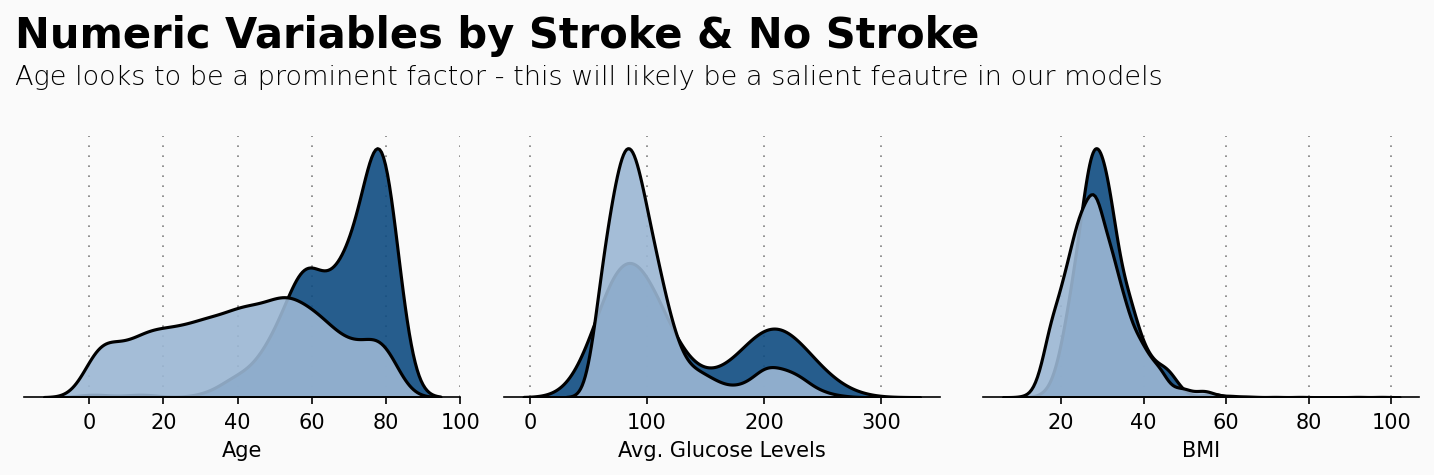

In [7]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = data[data['stroke'] == 1]
ns = data[data['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models',
         fontsize=13, fontweight='light')

plt.show()

## 2. Data preprocessing

### 2.1. Handle outlier

In [8]:
# TODO
data = data[data['gender'] != "Other"]

### 2.2. Handle missing data

In [9]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


The dataset had 201 samples with missing BMI value. Instead of
imputing it naively with the mean or the median, we used a simple **decision
tree model** to predict that based on gender and age.

In [10]:
DT_bmi_pipe = Pipeline([('scale',StandardScaler()),
                         ('lr',DecisionTreeRegressor(random_state=42))
                         ])
X = data[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1})
missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
y = X.pop('bmi')
DT_bmi_pipe.fit(X,y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing[['age','gender']]),index=missing.index)
data.loc[missing.index,'bmi'] = predicted_bmi
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### 2.3. Handle imbalance using SMOTE
(Done in cart section)
the best sample ratio is 0.4

### 2.4. Encode Categorial Features
Before encoding, we will split the data set

In [11]:
num_folds = 10
scoring = 'f1'
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=42)

SVM requires that each data instance is represented as a vector of real numbers.
Hence, if there are categorical attributes, we first have to convert them into numeric
data. There are 2 numerical types that can be converted to from categorical data: Ordinal or Nominal.

In [12]:
transformers = [('Standard-Nominal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                             remainder='passthrough')),
               ('Standard-Ordinal', ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                              ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                             remainder='passthrough')),
               ('Minmax-Nominal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                    ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                                                   remainder='passthrough')),
                ('Minmax-Ordinal', ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                                                      ('encode', OrdinalEncoder(), categorical_ix)],
                                                     remainder='passthrough'))
                ]

for name, transformer in transformers:
    model = Pipeline([(name, transformer),
                      ('SMOTE',SMOTE(sampling_strategy=0.4,random_state=42)),
                      ('SVC', SVC())])
    kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, error_score='raise', n_jobs=-1)

    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

Standard-Nominal: 0.166074 (0.057729)
Standard-Ordinal: 0.219750 (0.054001)
Minmax-Nominal: 0.158155 (0.082383)
Minmax-Ordinal: 0.229738 (0.061151)


If we don't use SMOTE before SVC, the nominal encode give us a higher score. But when we use SMOTE, the better score is ordinal.
Because later we'll use SMOTE to handle imbalanced data, we will choose ordinal encode for categorical data.

In [13]:
sm = SMOTE(sampling_strategy=0.4,random_state=42)



## 3. Enhance the algorithm
Tuning the estimator using Cross-validation and Grid-search

Parameter chosen range:
- Kernel: RBF
- C (penalty parameter): $$10^{-15} \to 10^{1}$$
- Gamma (kernel parameter): $$10^{-5} \to 10^{15}$$

In [ ]:
transformer = ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                        ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                       remainder='passthrough')
# Set the parameters
tuned_parameters = [dict(SVC__gamma= [10**x for x in range(-15,1,3)],
                     SVC__C = [10**x for x in range(-5,15,3)])]
model = Pipeline([('Trans', transformer),
                  ('SMOTE',SMOTE(sampling_strategy=0.4,random_state=42)),
                  ('SVC', SVC())])
kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
result = pd.DataFrame(columns=['gamma','C','score'])
GS1 = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS1.fit(X_train, y_train)
for para, mean_score, cv_score  in GS1.grid_scores_:
    para['score'] = mean_score
    result.append(para)
sns.relplot(x='C',y='gamma',hue='score',data=result,sizes='score',units='score')
print("the parameters {} are the best.".format(GS1.best_params_))
print("the best score is {:.2f}.".format(GS1.best_score_))

Finner Grid search

In [ ]:
transformer = ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                remainder='passthrough')
# Set the parameters
tuned_parameters = [dict(SVC__gamma= [2**x for x in np.arange(-5,-1,0.25)],
                         SVC__C = [2**x for x in np.arange(3,7,0.25)])]
model = Pipeline([('Trans', transformer),
                  ('SMOTE',SMOTE(sampling_strategy=0.4,random_state=42)),
                  ('SVC', SVC())])
kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
result = pd.DataFrame(columns=['gamma','C','score'])
GS2 = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=scoring, cv=kfold, n_jobs=-1)
GS2.fit(X_train, y_train)
for para, mean_score, cv_score  in GS1.grid_scores_:
    para['score'] = mean_score
    result.append(para)
sns.relplot(x='C',y='gamma',hue='score',data=result,sizes='score',units='score')
print("the parameters {} are the best.".format(GS2.best_params_))
print("the best score is {:.2f}.".format(GS2.best_score_))


## 4. Evaluation
Predict and evaluate the accuracy on test data

In [ ]:
transformer = ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(),categorical_ix)],
                                remainder='passthrough')

svc = Pipeline([('Trans', transformer),
                  ('SMOTE',SMOTE(sampling_strategy=0.4)),
                  ('SVC',SVC(C=7,gamma=0.2))
                 ])
svc.fit(X_train,y_train)

y_predict = svc.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))